# Fake News Detection

## Introduction

Fake news detection is a subject that has been getting a lot of press coverage in recent years. People make decisions based on the news they digest, and fake news gets in the way of the public making well-informed decisions. The community is overwhelmed with information and is unsure of what can be trusted. Often, the public ends up trusting inaccurate information. Many social media companies are currently trying to solve the issue of fake news spreading rapidly throughout their platforms. A reliable tool to identify untrustworthy news is needed to filter the information we receive.

We are trying to see if we can use text mining to classify news articles as real or fake based on the text in the article body and/or headline.

## The Data

We will make use of 2 main datasets, one of which will be used for training and the other for testing. 

Of course, the definition of "fake" news is not entirely straightforward. News is made up of many lines of text, some of which may contain bias, satire, exageration, and have some lines that are objectively false and some that are objectively true. 

For the purpose of this project, we will assume (or rather hope) that the datasets used somewhat accurately categorized news into "unreliable" and "reliable," meaning that the news classified as "unreliable" is primarily made of statements that are objectively false.  

In [2]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy

In [3]:
train = pd.read_csv("train1.csv",encoding='utf_8') ## read in train data
test = pd.read_csv("train2.csv",encoding='utf_8') ## read in test data


train = train.drop_duplicates(subset = ['title'], keep = 'first'); ##dedup train data
test = test.drop_duplicates(subset = ['title'], keep = 'first'); ##dedup test data

train = train.drop_duplicates(subset = ['text'], keep = 'first'); ##dedup train data
test = test.drop_duplicates(subset = ['text'], keep = 'first'); ##dedup test data

train.text = [str(text) for text in train.text]
test.text = [str(text) for text in test.text]
train.title = [str(title) for title in train.title]
test.title = [str(title) for title in test.title]


The training dataset was taken from a recent [kaggle competition on spotting fake news](https://www.kaggle.com/c/fake-news/data) (train.csv). 

The dataset contains 19510 instances and has the following features:

- ID
- Title
- Author
- Text
- Label (1 = "Unreliable", 0 = "Reliable")

We will only be using Title and Text as features to try and learn the concept of reliable vs unreliable news. We will not be using the author because we want to judge the documents on their content, rather than on their source. Further reasoning for this is that even historically reliable sources might public unreliable news, and vice-versa. 

Below is a sample set of the first 10 instances of data as an example:

In [4]:
train.head(10) ##show first 10 instances

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
5,5,Jackie Mason: Hollywood Would Love Trump if He...,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voi...",0
6,6,Life: Life Of Luxury: Elton John’s 6 Favorite ...,NaN,Ever wonder how Britain’s most iconic pop pian...,1
7,7,Benoît Hamon Wins French Socialist Party’s Pre...,Alissa J. Rubin,"PARIS — France chose an idealistic, traditi...",0
8,8,Excerpts From a Draft Script for Donald Trump’...,NaN,Donald J. Trump is scheduled to make a highly ...,0
9,9,"A Back-Channel Plan for Ukraine and Russia, Co...",Megan Twohey and Scott Shane,A week before Michael T. Flynn resigned as nat...,0


In [5]:
train.shape ##shows # instances and features

(19510, 5)

The testing dataset was taken from another [project found on github](https://github.com/GeorgeMcIntire/fake_real_news_dataset)). This dataset was labeled using the chrome "BS Detector Extension). 

The dataset contains 6011 instances and has the following features:

- ID
- Title
- Text
- Label ("Fake" & "Real")

We will only be using Title and Text as features to try and test our understanding of the concept of reliable vs unreliable news. 
Below is a sample set of the first 10 instances of data as an example:

In [6]:
test.head(10)

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
5,6903,"Tehran, USA","\nI’m not an immigrant, but my grandparents ...",FAKE
6,7341,Girl Horrified At What She Watches Boyfriend D...,"Share This Baylee Luciani (left), Screenshot o...",FAKE
7,95,‘Britain’s Schindler’ Dies at 106,A Czech stockbroker who saved more than 650 Je...,REAL
8,4869,Fact check: Trump and Clinton at the 'commande...,Hillary Clinton and Donald Trump made some ina...,REAL
9,2909,Iran reportedly makes new push for uranium con...,Iranian negotiators reportedly have made a las...,REAL


In [7]:
test.shape

(6011, 4)

For clarity and consistency between the two datasets, we will replace the 1 and "Fake" label values with "Unreliable" and the 0 and "Real" values with "Reliable."

In [8]:
train['label'] = train['label'].replace(1, 'Unreliable')
train['label'] = train['label'].replace(0, 'Reliable')
test['label'] = test['label'].replace('FAKE', 'Unreliable')
test['label'] = test['label'].replace('REAL', 'Reliable')

Let's make sure our labels are evenly distributed within our two datasets: 

<function matplotlib.pyplot.show(*args, **kw)>

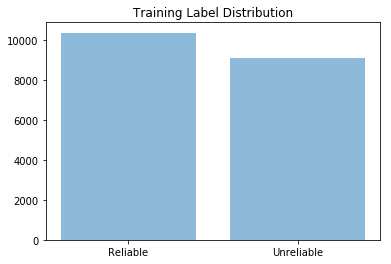

In [9]:
%matplotlib inline
counts = train['label'].value_counts();
labels = np.unique(train['label']);
y_pos = np.arange(len(labels));
plt.bar(y_pos, counts, align='center', alpha=0.5);
plt.xticks(y_pos, labels);
plt.title('Training Label Distribution');
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

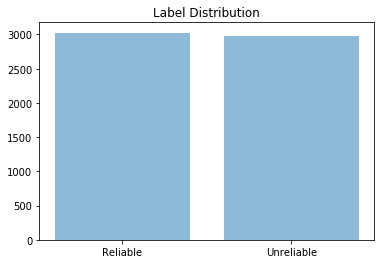

In [10]:
counts = test['label'].value_counts();
labels = np.unique(test['label']);
y_pos = np.arange(len(labels));
plt.bar(y_pos, counts, align='center', alpha=0.5);
plt.xticks(y_pos, labels);
plt.title('Label Distribution');
plt.show

Looks like labels are equally distributed in both the training and testing datasets, so we don't need to worry about problems caused by unequal label distributions. 

### Label Preprocessing

Although setting labels as "Reliable" and "Unreliable" is easier for a human understand, we should convert our labels to arrays with 0 and 1 values so that they can work with the ML packages, the below code will do this for us. 

In [11]:
from sklearn import preprocessing ### Importing a preprocessor to convert the labels in the target class.

In [12]:
class_y = ['Unreliable','Reliable']
le = preprocessing.LabelEncoder()
le.fit(class_y);

In [13]:
train_y = le.transform(train['label']) 
test_y = le.transform(test['label'])

In [14]:
## check if it worked:

print(le.transform(['Unreliable','Reliable','Reliable']))
print(train_y)
print(test_y)

[1 0 0]
[1 0 1 ... 0 0 1]
[1 1 0 ... 1 0 0]


## Feature Engineering

#### General Reasoning

The feature selection process will be the primary focus of this project. The different classification algorithms do similar things in slightly different ways, so we will just choose an algorithm (logistic regression for example) and stick with it. The way we choose to represent our data will have a much greater impact on our model performance and on our understanding of what works and what does not. 

To drive home the point, say we choose a poor feature representation. It will be almost impossible to classify news as real or fake, no matter which algorithm we choose. On the other hand, if we choose a feature representation that contains signal that is useful for classifying news as fake, any of the common classification algorithms should be able to correctly extract the relationship. 





#### Working with the Title

When looking for indicators of fake news, we should consider the possibility that if certain words appear in the title they might be more indicative of the article being fake than if they appeared in the body text, or vice-versa. To account for this, we must ensure that a word that appears in the title is treated as a seperate feature from the same word appearing in the text. 

We will create such features by appending "title_" to all words that appear in the title, and later merging the newly created titles with the text body into a single string. 

In [15]:
train_title = np.array(train['title'].astype('U'))
test_title = np.array(test['title'].astype('U'))

In [16]:
##function takes an array and a string and returns a new array with string_ appended to every word in the array

def word_appender(array, to_append):
    new_list = list()
    for row in array:
        new_row = ""
        for word in str.split(row):
            new_row = new_row + word.replace(word, to_append+"_"+word+" ")
        new_list.append(new_row)
    return np.asarray(new_list)

In [17]:
##convert title to new version 

train_title = word_appender(train_title, "title")
test_title = word_appender(test_title, "title")

In [18]:
##function will take 2 arrays of strings and combine the strings 
##(make sure last word ends in a space of first array for this to work properly, also arrays have to be same size)

def text_merger(array1, array2):
    new_list = list()
    for i in range(0,len(array2)):
        new_list.append(array1[i]+array2[i])    
    return np.asarray(new_list)

In [19]:
##run merger on train and test data

train_text = text_merger(train_title, np.array(train['text'].astype('U')))
test_text = text_merger(test_title, np.array(test['text'].astype('U')))

In [20]:
train_text[1][0:500] ##look at first 500 characters of random example to see if it worked

'title_FLYNN: title_Hillary title_Clinton, title_Big title_Woman title_on title_Campus title_- title_Breitbart Ever get the feeling your life circles the roundabout rather than heads in a straight line toward the intended destination? [Hillary Clinton remains the big woman on campus in leafy, liberal Wellesley, Massachusetts. Everywhere else votes her most likely to don her inauguration dress for the remainder of her days the way Miss Havisham forever wore that wedding dress.  Speaking of Great E'

#### Checking for URLs

Another potential indicator for whether an article is reliable or not is the number of hyperlinks that are included in the title/text. For example, articles that contain many hyperlinks might be more reliable because they are providing sources. Another possibility is that mostly fake news articles contain urls in the title/text as they try to point you to other fake news sources (such as clickbait articles). 

Below is some code that will help us work with urls.

In [21]:
import re

In [22]:
##writing function that will return # of urls in each instance, and the urls themselves

def url_finder(text_array):
    url_list = list()
    urlcount_list = list()
    for row in text_array: 
        urls = re.findall("(?P<url>https?://[^\s]+)", row)
        urlcount = len(urls)
        url_list.append(urls)
        urlcount_list.append(urlcount)
    return np.asarray(url_list), np.asarray(urlcount_list)

In [23]:
train_urls, train_urlcount = url_finder(train_text)
test_urls, test_urlcount = url_finder(test_text)

In [24]:
##lets see if worked
print(test_urls) 
print(test_urlcount)

print(train_urlcount.shape)
print(test_urlcount.shape)

[list([]) list(['https://t.co/VyTT49YvoE']) list([]) ... list([]) list([])
 list([])]
[0 1 0 ... 0 0 0]
(19510,)
(6011,)


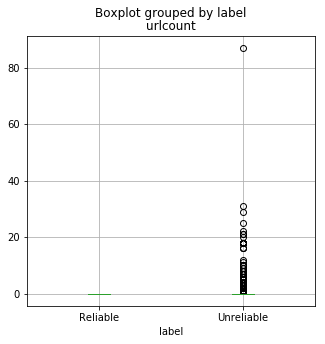

In [25]:
##Let's see whether there is any apparent relationship between # of URLs and Fake/Real News

%matplotlib inline

plots = pd.DataFrame({"urlcount": train_urlcount,
                        'label': np.asarray(train.label)})


plots.boxplot('urlcount', by='label', figsize = (5,5))

Interesting! It looks like reliable articles rarely contain URLs (the training dataset did not have any reliable articles with a url, while plenty of unreliable articles had many URLs). This makes sense, credible news sources want to claim credit for their news and would not want to link out to another page, while fake news sources might feel that links build credibility, or they just want users to continue clicking through to other fake news sources/clickbait links. 

#### Checking Article Length

The length of an article could also be indicative of whether it is likely to be real or fake, the following code creates the feature array (each entry is the # of characters in the text). We will also look to see if there is an obvious relationship using boxplots. 

In [26]:
def length_maker(text_array):
    lengths = list()
    for row in text_array:
        lengths.append(len(str(row)))
    return np.asarray(lengths)

train_lengths = length_maker(train['text'])
test_lengths = length_maker(test['text'])

print(train_lengths)
print(test_lengths)

[4930 4160 7692 ... 6059 4799 1773]
[ 7518  2646  2543 ... 11974  6991  4818]


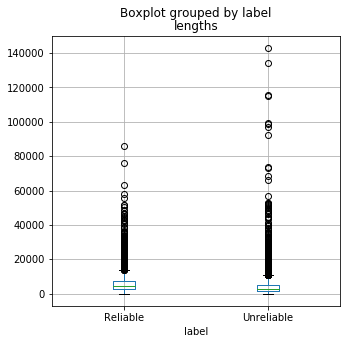

In [27]:
plots['lengths'] = train_lengths

%matplotlib inline
plots.boxplot('lengths', by='label', figsize = (5,5))

Not as a significant difference between the labels as with URLs. Unreliable news is a tiny bit shorter on average but has greater variance. 

#### Readability Index

How "readable" is each article. The package used to assess readability was taken from a public online source. "Readability" of an article is how "easy" it is to read (how complex is the article). It could be that fake news articles are written with a lower complexity than real news in order for them to be easy to understand (and more likely to go viral). The higher the "readability" score, the more complex the article text. 



In [28]:
## https://github.com/shivam5992/textstat
## test the gunning fog index for each instance
## evaluate the readability
from textblob import TextBlob
from textstat.textstat import textstat

%time train['readability_index'] = [textstat.gunning_fog(text) for text in train.text]
%time test['readability_index'] = [textstat.gunning_fog(text) for text in test.text]

CPU times: user 3min 1s, sys: 750 ms, total: 3min 2s
Wall time: 3min 3s
CPU times: user 1min, sys: 370 ms, total: 1min
Wall time: 1min


8349.6


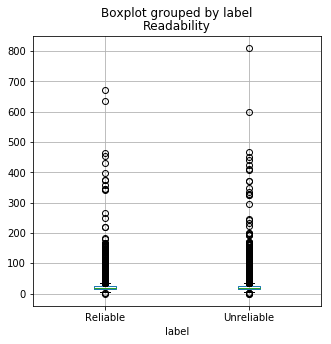

In [29]:
plots['Readability'] = train.readability_index

%matplotlib inline
plots.boxplot('Readability', by='label', figsize = (5,5))

print(max(train.readability_index))

Although there might be some slight differences in the distributions, it is hard to tell with just this boxplot.

#### Article Polarity & Subjectivity

The articles polarity (how strong is the articles stance) and subjectivity (how much opinion is in the article) could also be indicative of whether the article is reliable or not reliable. The algorithms for identifying article subjectivity and polarity are taken from an online source, and for the purposes of this project we will assume that the code accurately identifies article polarity and subjectivity as we defined it. 

In [30]:
## helper method to calculate polarity and subjectivity
def polarity(text):
    processed = TextBlob(text)
    polarity = processed.sentiment.polarity
    return polarity

def subj(text):
    processed = TextBlob(text)
    subj = processed.sentiment.subjectivity
    return subj

In [31]:
%time train['polarity'] = train.text.apply(polarity)

CPU times: user 1min 44s, sys: 204 ms, total: 1min 44s
Wall time: 1min 44s


In [32]:
%time train['subjectivity'] = train.text.apply(subj)

CPU times: user 1min 44s, sys: 177 ms, total: 1min 44s
Wall time: 1min 45s


In [33]:
%time test['polarity'] = test.text.apply(polarity)

CPU times: user 31.8 s, sys: 49 ms, total: 31.9 s
Wall time: 31.9 s


In [34]:
%time test['subjectivity'] = test.text.apply(subj)

CPU times: user 32.1 s, sys: 56.2 ms, total: 32.2 s
Wall time: 32.2 s


In [35]:
##Create arrays of our newly created features

train_polarity = np.asarray(train.polarity)
train_subjectivity = np.asarray(train.subjectivity)
train_readability = np.asarray(train.readability_index)


test_polarity = np.asarray(test.polarity)
test_subjectivity = np.asarray(test.subjectivity)
test_readability = np.asarray(test.readability_index)


print(train_polarity)
print(train_subjectivity)


[ 0.00677736  0.10088016  0.0562578  ...  0.05029713  0.11253968
 -0.01942641]
[0.48221596 0.49511031 0.40510745 ... 0.41382649 0.46638889 0.20963203]


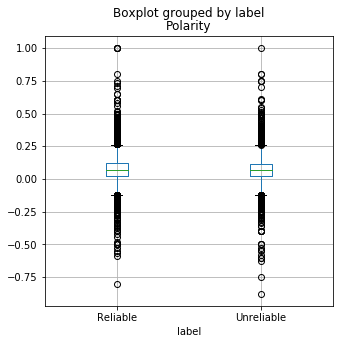

In [36]:
plots['Polarity'] = train.polarity

%matplotlib inline
plots.boxplot('Polarity', by='label', figsize = (5,5))

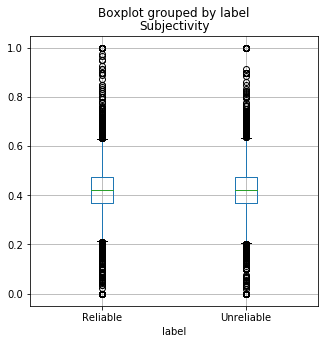

In [37]:
plots['Subjectivity'] = train.subjectivity

%matplotlib inline
plots.boxplot('Subjectivity', by='label', figsize = (5,5))

Again, it does not seem like there is a strong relationship between the reliability of an article and either its polarity or subjectivity that can be gleaned from the above box plots.

#### Word Vectorization

The main types of word vectorizers we will be trying out will be the bag of words and tfidf weighting (on the combined text + title attribute) in addition to the URL count, article length, text readability, text polarization, and text subjectivity). 

Both the bag of words and TFIDF weighting approaches convert the entire corpus into a set of features. The bag of words approach counts the number of times each word appears in an instance and assigns that count as the value for that feature in that instance. The TFIDF weights on the other hand do not just use the count of the word in the instance as the feature value, give greater weight to words that appear more in the instance but in less instances. The TFIDF approach should place greater emphasis on words that are uniquely important to each instance. 

We will definitely process all text with: 

- downcasing
- tokenizing (on spaces and removing punctuation)

We will not be stemming, since modified words are a choice of writing style that might be relevant, so we want to take differences between words such as "run" and "running" into account. 

Additionally, we will not be explicitly removing stop words (using the stop words feature). TFIDF should weigh stop words lightly anyway based on how it works. Certain selections of max_df for the bag of words and TFIDF representations should also remove most stop words. 

##### Parameters

For both TFIDF and Bag of Words we will be trying out a few different parameter selections:

- N-Grams (we will try 1-grams, 1-2grams, and 2 grams. We know that individual words used can be indicative of whether an article is real or fake, but so can phrases of varying lengths, so we will try everything that is reasonable with our computing power)

- min_df, max_df (try different cutoff values for % of instances that words appear in). We will start with the largest set and iterate by cutting equal percentage from each side. We want to see what happens when we shrink the feature set.  

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack

In [39]:
##initiate parameter values through which we will iterate

df_iter = [[.05,.95],[.1,.9],[.2,.8]]

The following code consists of two functions that will work together in order to create several feature arrays by iterating through various n-gram settings and df ranges (as initialized in cell above). So the final output would be a dataframe with a different feature arrays for different combinations of n_gram and df range parameters. Additionally, each iteration will have a count representation and a TFIDF weighting representation. The previously engineered features (urlcount, length, readability, polarity, and subjectivity) will be appended to the end of each word vector array as the final 5 features. 

In [40]:
def feature_maker(text, vectorizers, url, length, text_readability, text_polarity, text_subjectivity):
    features = list()
    sizes = list()
        
    for vectorizer in vectorizers:
        features.append(hstack((vectorizer.fit_transform(text),
                                url[:,None],
                                length[:,None],
                                text_polarity[:,None],
                                text_subjectivity[:,None],
                                text_readability[:,None])).toarray())
        sizes.append(features[-1].shape)
        
    return features, sizes

def vectorizer_maker(text, df_iter, n_gram_max, url, length, text_readability, text_polarity, text_subjectivity):
    vectorizers = list()
    dfs = list()
    gram = list()
    Type = list()
    for t in ['count', 'tfidf']:
        for low in range(1,n_gram_max+1):
            for high in range(low,n_gram_max+1):
                for df in df_iter:
                    dfs.append(df)
                    gram.append(str(low) + "-" + str(high))
                    Type.append(t)
                    if t == 'count':
                        vectorizers.append(CountVectorizer(min_df = df[0], 
                                                           max_df = df[1], 
                                                           max_features = 5000, 
                                                           ngram_range= (low,high)))
                        
                    else: 
                        vectorizers.append(TfidfVectorizer(min_df = df[0], 
                                                           max_df = df[1], 
                                                           max_features = 5000, 
                                                           ngram_range= (low,high)))
                        
    features, shape = feature_maker(text, vectorizers, url, length, text_readability, text_polarity, text_subjectivity)
    frame = pd.DataFrame({'grams': gram,
                         'dfs': dfs,
                         'vectorizers': vectorizers,
                          'features': features,
                          'shape': shape,
                          'type': Type
                         }
                        )
    return frame



In [41]:
%time feature_set = vectorizer_maker(train_text, df_iter, 2, train_urlcount, train_lengths, train_readability, train_polarity, train_subjectivity)

CPU times: user 12min 25s, sys: 1min 33s, total: 13min 58s
Wall time: 13min 56s


In [42]:
feature_set

,grams,dfs,vectorizers,features,shape,type
0,1-1,"[0.05, 0.95]","CountVectorizer(analyzer='word', binary=False,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","(19510, 1261)",count
1,1-1,"[0.1, 0.9]","CountVectorizer(analyzer='word', binary=False,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0,...","(19510, 560)",count
2,1-1,"[0.2, 0.8]","CountVectorizer(analyzer='word', binary=False,...","[[0.0, 0.0, 2.0, 7.0, 3.0, 0.0, 5.0, 0.0, 2.0,...","(19510, 210)",count
3,1-2,"[0.05, 0.95]","CountVectorizer(analyzer='word', binary=False,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","(19510, 1894)",count
4,1-2,"[0.1, 0.9]","CountVectorizer(analyzer='word', binary=False,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0,...","(19510, 764)",count
5,1-2,"[0.2, 0.8]","CountVectorizer(analyzer='word', binary=False,...","[[0.0, 0.0, 2.0, 7.0, 0.0, 3.0, 3.0, 0.0, 5.0,...","(19510, 270)",count
6,2-2,"[0.05, 0.95]","CountVectorizer(analyzer='word', binary=False,...","[[0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 3.0, 0.0, 2.0,...","(19510, 638)",count
7,2-2,"[0.1, 0.9]","CountVectorizer(analyzer='word', binary=False,...","[[0.0, 0.0, 3.0, 0.0, 2.0, 0.0, 0.0, 0.0, 1.0,...","(19510, 209)",count
8,2-2,"[0.2, 0.8]","CountVectorizer(analyzer='word', binary=False,...","[[0.0, 3.0, 2.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0,...","(19510, 65)",count
9,1-1,"[0.05, 0.95]","TfidfVectorizer(analyzer='word', binary=False,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","(19510, 1261)",tfidf


We have created 18 total word vector representations of our training data. Notice how as our df range shrinks the number of features in the representation decreases. When we cut out unigrams that appear in less than 5% and more than 95% of the documents, we are left with 1261 features (1256 different words, since 5 of the features we engineered previously). When we cut out unigrams that appear in less than 20% and more than 80% of the documents, we only have 65 features. Lets take a look at some of the feature names (they should be the same features for bag of words vs tfidf as long as the other parameters are the same, since all that changes between BoW and TFIDF is the weighting of the features):

In [43]:
feature_set.vectorizers[3].get_feature_names()[175:200]

['at',
 'at all',
 'at least',
 'at the',
 'at this',
 'attack',
 'attacks',
 'attempt',
 'attention',
 'attorney',
 'august',
 'author',
 'authorities',
 'authority',
 'available',
 'average',
 'avoid',
 'away',
 'away from',
 'back',
 'back to',
 'bad',
 'bank',
 'barack',
 'barack obama']

Looking at a random sample of 25 feature names created by the 1-2gram representation, it is not immediately clear which words can be significant in predicting unreliable news, although perhaps the subjective word "bad" should not appear in a reliable news article. 

### Model Selection

We will use the logistic regression classification algorithm to fit our model. Logistic regression is an efficient choice that also provides interpretable results in the form of coefficients for each feature. The features with the most positive coefficients means their appearance in an instance increases the likelihood that that instance is 'unreliable' news.

Again, we will not be trying out various models and altering model parameters (unless we see some really strange results) because our main priority is to see what kind of feature representations perform best. We also want to be interpret the impact different features have on the results. 

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import MultinomialNB

In [45]:
log_reg = LogisticRegression(C=4.0, solver = 'liblinear')

### Metrics & Evaluation

We will be using precision regarding the "unreliable" class as our metric. The reasoning for this is that we are only interested in spotting "fake" news. We would want the results of this project to lead to a method that can accurately flag articles from social media platforms that are "fake," so that they can be brought to the attention of a moderator or outright removed assuming the model performs well. Precision thus makes sense because if we identify an article as fake, we want to be as sure as possible that it is fake. Additionally, we know that it would be impossible to identify all the fake news articles out there as fake, and doing so while also identifying tons of real news as fake would not be useful, so a metric like recall would not make sense. 

Ultimately, we want to pick away at the number of fake news articles in circulation, slowly improving our methodology to catch more and more. From the get go, even if we do not identify a lot of fake news articles, the ones that we do identify to be fake, we want to be sure they are fake. We will be adjusting the prediction probability threshold to see how high we can get our precision. We will do this so that we do not only predict an article to be unreliable if it is more likely to be unreliable (such as when you do not set a threshold). Getting a prediction probability of 55% unreliable is not ideal, since even though such an instance is more likely to be unreliable, we are not certain enough to outright flag it or remove it (although we will see how our model performs using this threshold). Theoretically if we set threshold of %99.9, we should have near perfect accuracy, although we will not capture that many unreliable news articles. 

We will first test our results using 20-Fold Cross Validation, and then we will test it on the second data set to see if our results are generalizable. 

In [46]:
##perform 20-Fold CV on each of our 18-feature representations.

feature_set['20CV_Precision'] = [cross_val_score(log_reg, 
                                  features, 
                                  train_y, 
                                  scoring='precision', 
                                  cv=20).mean() for features in feature_set.features]

In [47]:
feature_set[['grams','dfs','shape','type','20CV_Precision']]

,grams,dfs,shape,type,20CV_Precision
0,1-1,"[0.05, 0.95]","(19510, 1261)",count,0.959493
1,1-1,"[0.1, 0.9]","(19510, 560)",count,0.937187
2,1-1,"[0.2, 0.8]","(19510, 210)",count,0.896539
3,1-2,"[0.05, 0.95]","(19510, 1894)",count,0.963508
4,1-2,"[0.1, 0.9]","(19510, 764)",count,0.940971
5,1-2,"[0.2, 0.8]","(19510, 270)",count,0.898568
6,2-2,"[0.05, 0.95]","(19510, 638)",count,0.930368
7,2-2,"[0.1, 0.9]","(19510, 209)",count,0.902046
8,2-2,"[0.2, 0.8]","(19510, 65)",count,0.722456
9,1-1,"[0.05, 0.95]","(19510, 1261)",tfidf,0.901512


Text(0, 0.5, 'Precision')

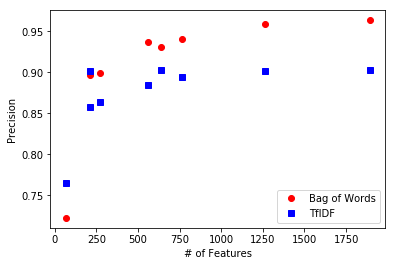

In [48]:
import matplotlib.pyplot as plt
import matplotlib.pylab as lab

feature_set['num_features'] = [shape[1] for shape in feature_set['shape']]

plt.plot(feature_set.num_features[feature_set['type'] == "count"], 
         feature_set['20CV_Precision'][feature_set['type'] == "count"], 
         'ro',
         feature_set.num_features[feature_set['type'] == "tfidf"], 
         feature_set['20CV_Precision'][feature_set['type'] == "tfidf"],
         'bs')


plt.legend(['Bag of Words', 'TfIDF'])
plt.xlabel('# of Features')
plt.ylabel('Precision')





It appears that the count feature representation almost always performs better than the corresponding tfidf representation. It is interesting however that although the bag of words representation performs better than TfIDF, it looks like TfIDF is able to reach its top precision values with much fewer features. 

Our best results were the unigram + bigram representation with words that appeared in more than 5% of the documents and less than 95% of the documents (0.963 Precision). The second best results were from the unigram representation (0.959 Precision), however this representation had ~600 less features and almost no loss in quality. 

Although it is clear which representation performs best when evaluated using cross-validation, we always run the risk of overfitting if we do not test on an completely external data source. Let's see how our model generalizes when we run predictions on the second dataset. 

First, we must transform our test data into our 18 feature representations:

In [49]:
def test_feature_maker(text, vectorizers, url, length, text_readability, text_polarity, text_subjectivity):
    features = list()
    sizes = list()
        
    for vectorizer in vectorizers:
        features.append(hstack((vectorizer.transform(text),
                                url[:,None],
                                length[:,None],
                                text_polarity[:,None],
                                text_subjectivity[:,None],
                                text_readability[:,None])).toarray())
        sizes.append(features[-1].shape)
        
    return features, sizes

In [50]:
test_features, test_sizes = test_feature_maker(test_text, feature_set.vectorizers, test_urlcount, test_lengths, test_readability, test_polarity, test_subjectivity)

In [51]:
test_results = pd.DataFrame({'test_features': test_features,
                             'test_vectorizers': feature_set.vectorizers,
                            'test_shape': test_sizes})

test_results

,test_features,test_vectorizers,test_shape
0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","CountVectorizer(analyzer='word', binary=False,...","(6011, 1261)"
1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","CountVectorizer(analyzer='word', binary=False,...","(6011, 560)"
2,"[[0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 1.0, 4.0, 5.0,...","CountVectorizer(analyzer='word', binary=False,...","(6011, 210)"
3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","CountVectorizer(analyzer='word', binary=False,...","(6011, 1894)"
4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","CountVectorizer(analyzer='word', binary=False,...","(6011, 764)"
5,"[[0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 1.0,...","CountVectorizer(analyzer='word', binary=False,...","(6011, 270)"
6,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","CountVectorizer(analyzer='word', binary=False,...","(6011, 638)"
7,"[[0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 1.0, 0.0,...","CountVectorizer(analyzer='word', binary=False,...","(6011, 209)"
8,"[[0.0, 0.0, 0.0, 0.0, 4.0, 1.0, 3.0, 4.0, 1.0,...","CountVectorizer(analyzer='word', binary=False,...","(6011, 65)"
9,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","TfidfVectorizer(analyzer='word', binary=False,...","(6011, 1261)"


Next, we will fit our 18 logistic regression models and make predictions on the test set, seeing which one has the best precision. We will check results with a 50% threshold, 90% threshold, and a 99% threshold.

In [52]:
def evaluator(fitting, testing, train_y, test_y, model, strength):
    predictions = list()
    prediction_probs = list()
    precision = list()
    pred = list()
    true = list()
    for i in range(0,len(testing)):
        true_pos = 0
        pred_pos = 0
        model.fit(fitting[i], train_y)
        predictions.append(model.predict(testing[i]))
        prediction_probs.append(model.predict_proba(testing[i]))
        for j in range(0, len(prediction_probs[-1])):
            if prediction_probs[-1][j][1] >= strength:
                pred_pos+=1
                if test_y[j] == 1:
                    true_pos+= 1
        precision.append(true_pos/pred_pos)
        pred.append(pred_pos)
        true.append(true_pos)
        
    new_precision = pd.DataFrame({'pred_pos': pred,
                              'true_pos': true,
                              'precision': precision})
    return np.asarray(predictions), np.asarray(prediction_probs), new_precision
        
    


In [53]:
predictions_50per, prediction_probs_50per, precision_50per = evaluator(feature_set.features, test_results.test_features, train_y, test_y, log_reg, .5)

In [54]:
predictions_90per, prediction_probs_90per, precision_90per = evaluator(feature_set.features, test_results.test_features, train_y, test_y, log_reg, .9)

In [55]:
predictions_99per, prediction_probs_99per, precision_99per = evaluator(feature_set.features, test_results.test_features, train_y, test_y, log_reg, .99)

In [56]:
predictions_999per, prediction_probs_999per, precision_999per = evaluator(feature_set.features, test_results.test_features, train_y, test_y, log_reg, .999)

In [57]:
predictions_9999per, prediction_probs_9999per, precision_9999per = evaluator(feature_set.features, test_results.test_features, train_y, test_y, log_reg, .9999)

In [58]:
print(precision_9999per)

    pred_pos  true_pos  precision
0       1054       920   0.872865
1        648       561   0.865741
2        419       365   0.871122
3       1268      1064   0.839117
4        520       454   0.873077
5        394       339   0.860406
6        219       189   0.863014
7        151       133   0.880795
8         67        66   0.985075
9        111       110   0.990991
10        51        49   0.960784
11        52        50   0.961538
12        53        51   0.962264
13        52        50   0.961538
14        50        48   0.960000
15        56        54   0.964286
16        87        85   0.977011
17        69        67   0.971014


In [59]:
final_set = feature_set[['grams','dfs','type','num_features','20CV_Precision']].copy()
final_set['50_percent_precision'] = precision_50per['precision']
final_set['50_percent_#predicted'] = precision_50per['pred_pos']
final_set['99_percent_precision'] = precision_99per['precision']
final_set['99_percent_#predicted'] = precision_99per['pred_pos']
final_set['999_percent_precision'] = precision_999per['precision']
final_set['999_percent_#predicted'] = precision_999per['pred_pos']
final_set['9999_percent_precision'] = precision_9999per['precision']
final_set['9999_percent_#predicted'] = precision_9999per['pred_pos']

final_set

,grams,dfs,type,num_features,20CV_Precision,50_percent_precision,50_percent_#predicted,99_percent_precision,99_percent_#predicted,999_percent_precision,999_percent_#predicted,9999_percent_precision,9999_percent_#predicted
0,1-1,"[0.05, 0.95]",count,1261,0.959493,0.638823,4657,0.778744,2531,0.831106,1646,0.872865,1054
1,1-1,"[0.1, 0.9]",count,560,0.937187,0.623779,4710,0.783325,1943,0.837788,1085,0.865741,648
2,1-1,"[0.2, 0.8]",count,210,0.896539,0.610376,4607,0.769231,1274,0.817109,678,0.871122,419
3,1-2,"[0.05, 0.95]",count,1894,0.963508,0.624610,4803,0.751645,2887,0.804314,1901,0.839117,1268
4,1-2,"[0.1, 0.9]",count,764,0.940971,0.621514,4769,0.797321,1717,0.847947,901,0.873077,520
5,1-2,"[0.2, 0.8]",count,270,0.898568,0.607953,4627,0.758140,1290,0.801178,679,0.860406,394
6,2-2,"[0.05, 0.95]",count,638,0.930368,0.559630,5291,0.719643,1120,0.798687,457,0.863014,219
7,2-2,"[0.1, 0.9]",count,209,0.902046,0.554623,5245,0.749679,779,0.829431,299,0.880795,151
8,2-2,"[0.2, 0.8]",count,65,0.722456,0.563460,4948,0.948113,212,0.983333,120,0.985075,67
9,1-1,"[0.05, 0.95]",tfidf,1261,0.901512,0.674133,4241,0.976150,587,0.985849,212,0.990991,111


Text(0, 0.5, 'Precision')

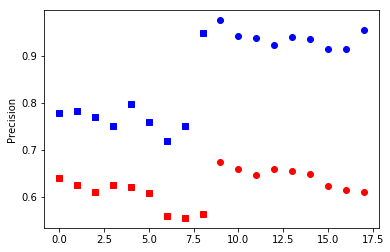

In [60]:
plt.plot(final_set[final_set['type']=='count']['50_percent_precision'], 'rs')
plt.plot(final_set[final_set['type']=='count']['99_percent_precision'], 'bs')
plt.plot(final_set[final_set['type']=='tfidf']['50_percent_precision'], 'ro')
plt.plot(final_set[final_set['type']=='tfidf']['99_percent_precision'], 'bo')
plt.ylabel('Precision')
#plt.legend('50percent-count', '99percent-count')
#plt.plot(final_set['999_percent_precision'], 'gx')
#plt.plot(final_set['9999_percent_precision'], 'k<')

The results are fascinating. It appears that when testing on a previously unseen dataset, the TFIDF representations all perform better than the count representation (the opposite was true when performing 20-Fold CV). This means that TFIDF is a superior representation when it comes to creating a generalizable model (bag of words performed well on the original dataset but did not generalize at all!). 

From the TFIDF representations, it appears that they all performed quite well. While some significance testing could be useful in identifying the one that truly performed best based on how many features it had, for the purpose of error evaluation and getting to better understand our model, let's select the one that performed best with a 99% probability threshold (tfidf unigrams with .05,.95 df range. Precision: 0.976). 

Using this model we will see if we can push the precision to 100% using different threshold settings and see how many predictions we are making when pushing this threshold. 

In [61]:
thresholds = pd.DataFrame({"50% Threshold":precision_50per.iloc[9],
               "90% Threshold":precision_90per.iloc[9],
               "99% Threshold":precision_99per.iloc[9],
               "999% Threshold":precision_999per.iloc[9],
               "9999% Threshold":precision_9999per.iloc[9]})

thresholds

,50% Threshold,90% Threshold,99% Threshold,999% Threshold,9999% Threshold
pred_pos,4241.000000,2012.000000,587.00000,212.000000,111.000000
true_pos,2859.000000,1803.000000,573.00000,209.000000,110.000000
precision,0.674133,0.896123,0.97615,0.985849,0.990991


Text(0.5, 1.0, 'Precision vs. Threshold %')

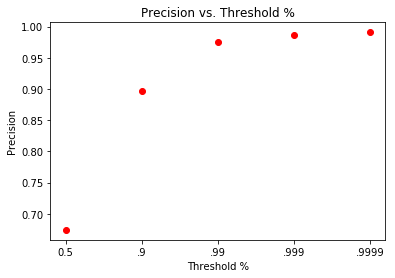

In [73]:
threshold_plotter = pd.DataFrame({"Threshold %": ['0.5', '.9', '.99', '.999','.9999'],
                                 "Precision": thresholds.iloc[2],
                                 "True Positives": thresholds.iloc[1]})
plt.plot(threshold_plotter["Threshold %"], threshold_plotter["Precision"], "ro")
plt.ylabel('Precision')
plt.xlabel('Threshold %')
plt.title('Precision vs. Threshold %')

Text(0.5, 1.0, '# Predictions vs. Threshold %')

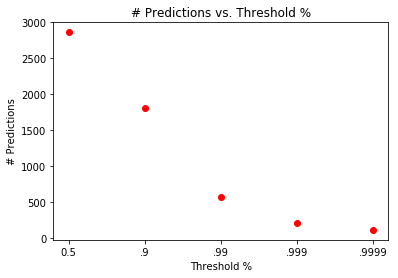

In [75]:
plt.plot(threshold_plotter["Threshold %"], threshold_plotter["True Positives"], "ro")
plt.ylabel('# Predictions')
plt.xlabel('Threshold %')
plt.title('# Predictions vs. Threshold %')

It looks like using the selected logistic regression model makes it possible for us to achieve near perfect precision! With a 99% threshold we predicted 587 instances to be unreliable, of which 573 were actually unreliable (14 errors, 97.6% precision). As we increased out threshold to 99.9%, we predicted 212 instances to be unreliable, of which 209 were actually unreliable (3 errors, 98.5% Precision). Finally at a threshold of 99.99% , we predicted 111 instances to be unreliable of which 110 were actually unreliable (1 error, 99% precision). 

It appears that our increases in threshold had only a marginal increase on our precision, but we made half as many predictions with each increase. Likely any of these values above 99% would be fine for a company to use to flag fake news with a great amount of confidence, but in order for us to be sure, we need to get a better understanding of what the model is doing, and where it went wrong even with a 99.99% threshold! 

### Model Interpretation and Error Analysis

To better understand our model, lets take a look at the coefficients assigned to each feature. The highest values will give us insight into which features are most predictive of unreliable news according to our model. 

In [77]:
log_reg.fit(feature_set.features[9], train_y)

LogisticRegression(C=4.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [167]:
top100 = log_reg.coef_[0].argsort()[::-1][0:100]
print(top100)

top100 = top100[top100 <= 1255]

unreliable_coefs = log_reg.coef_[0,top100]
unreliable_words = np.asarray(feature_set.vectorizers[9].get_feature_names())[top50]

bottom100 = log_reg.coef_[0].argsort()[0:100]
bottom100 = bottom100[bottom100 <= 1255]

reliable_coefs = log_reg.coef_[0,bottom100]
reliable_words = np.asarray(feature_set.vectorizers[9].get_feature_names())[bottom100]

[  21  507 1160  229  752  746   89 1256 1096  979   66 1013  762  357
 1187  177  404  662  564   67  522    3  106   99 1239  938 1169  361
  898 1182  819  238   26  133 1172  144 1089  530   27  147  237 1029
 1110 1120  293  939    8    1 1222 1207 1128  927  233  396  360  837
   38  751  834 1113 1121  159  737  689 1116  668  869   28 1203  747
 1118  952 1117 1193 1014 1109   78  165  583 1064   46 1158 1220  656
 1060  173 1255 1178  103 1002  692  138 1142 1058 1087  738  466  358
  969  157]


In [165]:
reliable_words
#reliable_coefs

array(['title_breitbart', 'said', 'mr', 'breitbart', 'twitter', 'follow',
       '2017', 'title_', 'on', 'ms', 'president', 'title_york', 'that',
       'title_times', 'title_new', 'at', 'its', 'mrs', 'percent',
       'administration', 'sunday', 'march', 'immigration', 'new',
       'islamic', 'york', 'house', 'game', 'but', 'last', 'friday', 'you',
       'senate', 'january', 'saturday', 'in', 'united', 'executive',
       'texas', 'an', 'week', 'statement', 'democrats', 'added', 'think',
       'with', 'series', 'news', 'officials', 'speech', 'for', 'border',
       'former', 're', 'attack', 'who', 'and', 'republicans', 'monday',
       'thursday', 'host', 'show', 'team', 'it', 'times', 'bill', 'wrote',
       'february', 'weekend', 'continued', 'whether', 'april',
       'committee', 'including', 'university', 'director', 'reporter',
       'than', 'like', 'care', 'cnn', 'she', 'during', 'decision', 'tax',
       'security', 'tuesday', 'more', 'company', 'union', 'june', 'we',
    

In [166]:
unreliable_words

array(['2016', 'hillary', 'us', 'clinton', 'october', 'november', 'anti',
       'this', 'share', 'al', 'source', 'old', 'election', 'war', 'by',
       'fbi', 'man', 'is', 'all', 'however', '11', 'article', 'are',
       'world', 'russia', 'via', 'emails', 'related', 'voting', 'please',
       'comments', '26', 'be', 'video', 'being', 'these', 'image', '27',
       'below', 'comment', 'standing', 'title_and', 'title_of', 'de',
       'russian', '16', '10', 'will', 'western', 'today', 'right', 'com',
       'fact', 'email', 'power', 'access', 'obama', 'post', 'title_by',
       'title_on', 'body', 'no', 'military', 'title_hillary', 'massive',
       'putin', '28', 'well', 'now', 'title_is', 'secret', 'title_in',
       'water', 'sources', 'title_a', 'am', 'breaking', 'just', 'system',
       'actually', 'up', 'why', 'mainstream', 'supporters', 'bush',
       'your', 'vote', 'army', 'so', 'mind', 'been', 'truth', 'support',
       'then', 'nominee', 'god', 'elections', 'september', 'bla

The "unreliable words" are the top 99 features that are most significant in predicting unreliable news according to our model. In addition to the words above, the url_count was also a significant feature (as expected based on the boxplot seen earlier). 

The words seen here "make sense" in a way, but show that this model is flawed. Without context, the words identified by the model are not outright predictors of unreliable news, but during the 2016 election they were. Some words, such as "truth" and "sources" might make sense in general context, while the rest of the words seem to be too specifically related to the 2016 elections and political scandals. This shows why our model did not generalize too well to the external data source. Additionally, it shows why we can still get high precision by setting a high threshold. If we set the threshold to 99%, then the articles that are predicted to be unreliable will likely contain many of the unreliable words found in our training corpus. 

Now let's take a look at the 1 instance that was incorrectly classified as unreliable even with a 99.99% threshold.

In [247]:
p = prediction_probs_9999per[9]

percentages = [percentage[1] for percentage in p]

pred_unreliable = [predict >= .9999 for predict in percentages]

checker = pd.DataFrame({"Predicted Unreliable": pred_unreliable,
                        "Label": test_y,
                        "Text": test_text})

print(checker[(checker['Predicted Unreliable'] == True) & (checker.Label == 0)].Text)

misclass_article = test_text[2762]

print(misclass_article)


2762    title_Poll: title_Clinton title_leads title_Tr...
Name: Text, dtype: object
title_Poll: title_Clinton title_leads title_Trump title_by title_three title_points With less than two weeks to go, the race for the White House has narrowed as Hillary Clinton now has a three-point advantage over Donald Trump.

That’s within the margin of error of the national Fox News Poll of likely voters.

Clinton is ahead of Trump by 44-41 percent.  Another one-in-ten back a third-party candidate and four percent are undecided.  Last week she was up by six points (45-39 percent) and before that by seven (45-38 percent).

The poll, released Wednesday, finds Clinton leads 49-44 percent in the head-to-head matchup.  That 5-point advantage is at the edge of the error margin.  She was up 7 a week ago (49-42 percent).

CLICK HERE TO READ THE FULL POLL RESULTS.

Trump is helped by increased backing among independents and greater strength of support: 68 percent of those backing Trump support him “strongly,

Our model was 99.99% sure that the above article was unreliable, despite it being reliable. 

In [249]:
misclass_article_features = feature_set.vectorizers[9].inverse_transform(test_results.test_features[9][2762][:-5])

print(misclass_article_features)

[array(['10', '11', '12', '13', '14', '15', '16', '18', '20', '2008',
       '2016', '22', '25', '26', '27', '28', '30', '40', 'about',
       'across', 'addition', 'additional', 'ago', 'ahead', 'all',
       'almost', 'also', 'although', 'among', 'an', 'and', 'another',
       'april', 'are', 'areas', 'as', 'at', 'attention', 'away', 'back',
       'based', 'be', 'because', 'before', 'believe', 'best', 'both',
       'but', 'by', 'candidate', 'candidates', 'choice', 'clinton',
       'close', 'college', 'company', 'compared', 'continues', 'couple',
       'crisis', 'decision', 'democratic', 'democrats', 'despite',
       'district', 'don', 'donald', 'down', 'each', 'economy', 'eight',
       'election', 'even', 'expect', 'favor', 'feel', 'first', 'five',
       'for', 'foreign', 'four', 'fox', 'from', 'full', 'fully', 'gets',
       'go', 'greater', 'groups', 'had', 'half', 'has', 'have', 'he',
       'head', 'helped', 'her', 'here', 'hillary', 'him', 'his', 'house',
       'if', 'imm

The above are the words in the text that also made it as features in our model. Lets see which of the words are also in the top 100 unreliable words list:

In [254]:
unreliable_words[np.isin(unreliable_words, np.asarray(misclass_article_features))]


array(['2016', 'hillary', 'clinton', 'october', 'this', 'election', 'by',
       'is', 'all', '11', 'are', 'voting', '26', 'be', '27', 'russian',
       '16', '10', 'will', 'title_by', 'putin', '28', 'now', 'just', 'up',
       'supporters', 'vote', 'support', 'september'], dtype='<U15')

The above are all words that the model believes to be indicative of unreliable news, and they were found in the reliable news article that ultimately ended up misclassified even with a 99.99% threshold. 

This shows that the data we used was not ideal for spotting fake news, as majority of unreliable news articles must have contained seemingly innocuous political words related to the 2016 elections. 